In [1]:
using Plots
using LinearAlgebra
using DelimitedFiles
using ProgressMeter
using LaTeXStrings
using StatsBase
using JLD2

In [2]:
function rand_state(N::Int)
    ψ = rand([1,-1], N)
    return ψ
end

rand_state (generic function with 1 method)

In [3]:
function rand_fields(N::Int)
    ϕ = randn(N)
    return ϕ
end

rand_fields (generic function with 1 method)

In [27]:
function interactions(N::Int)
    int = randn(N, N)/N
    int = 0.5*(int + int')
    for i in 1:N
        int[i, i] = 0  # Set the diagonal elements to zero using a loop
    end
    return int
end


interactions (generic function with 1 method)

In [28]:
# Compute Energy Change

function ΔE(ψ::Vector; h::Vector{Float64}, J::Matrix{Float64}, i::Int)
    ΔE = 2*ψ[i]*(h[i] + dot(J[i, :], ψ)) # The dot product is O(N)
    return ΔE
end

ΔE (generic function with 1 method)

In [29]:
# Perform a Monte-Carlo sweep

function MC_sweep(ψ::Vector, N::Int; h::Vector{Float64}, J::Matrix{Float64})
    ψ1 = copy(ψ)
    
    for i in 1:N
        s = rand(1:N)
        δE = ΔE(ψ, h = h, J = J, i = s)
        p = exp(-δE)
        # Spin flips with probability p (certainly if p ≥ 1)
        rand() < p && (ψ1[s] *= -1) 
    end
    
    return ψ1
end

MC_sweep (generic function with 1 method)

In [30]:
# Metropolis-Hastings algorithm

function MH(ψ::Vector, N::Int, S::Int; n::Int,
        h::Vector{Float64}, J::Matrix{Float64})
    C_ij = zeros(N, N)
    states = Vector{Vector{Int}}()

    # Thermalization
    for _ in 1:n
        ψ = MC_sweep(ψ, N; h = h, J = J)
    end

    # Rejection Sampling
    for i in 1:5*S
        ϕ = copy(ψ)
        ψ = MC_sweep(ψ, N; J = J, h = h)
        if i%5 == 0
            C_ij += ψ*ψ'
            push!(states, copy(ψ))
        end
    end
    
    # Mean Magnetisation and Correlations
    M = mean(hcat(states...), dims=2)
    C_ij ./= S

    return M, C_ij, states
end

MH (generic function with 1 method)

In [31]:
# Compute negative log likelihood for a sample of configurations

function negative_log_likelihood(states::Vector{Vector{Int}})
    N = length(states)
    
    counts = collect(values(countmap(states)))
    PMF = counts/N
    NLL = -(1/N)*sum(counts.*log.(PMF))

    return NLL
end

negative_log_likelihood (generic function with 1 method)

In [40]:
# Recursive update schemes for fields and interactions

function h_up(h::Vector{Float64}, η::AbstractFloat;
        M_d::Vector{Float64}, M::Vector{Float64})
    h_up = h + η*(M_d - M)
    return h_up
end

function J_up(J::Matrix{Float64}, η::AbstractFloat;
        Cij_d::Matrix{Float64}, Cij::Matrix{Float64})
    J_up = J + η*(Cij_d - Cij)
    for i in 1:N
        J_up[i, i] = 0  # Set the diagonal elements to zero using a loop
    end
    return J_up
end


J_up (generic function with 1 method)

In [41]:
# Boltzmann Learning Algoritm

function boltzmann_learn(S::Int, iterations::Int; η::AbstractFloat, 
        n::Int, N::Int, M_d::Matrix{Float64}, Cij_d::Matrix{Float64})
    h = rand_fields(N)
    J = interactions(N)

    NLL_monitor = Float64[]
    
    @showprogress for i in 1:iterations
        
        M, Cij, states = MH(rand_state(N), N, S; n = n, h = vec(h), J = J)
        h = h_up(h, η, M_d = vec(M_d), M = vec(M))
        J = J_up(J, η, Cij_d = Cij_d, Cij = Cij)
        
        NLL = negative_log_likelihood(states)
        push!(NLL_monitor, NLL)

    end
    
    return h, J, NLL_monitor
end

boltzmann_learn (generic function with 1 method)

In [42]:
N = 5
ψ = rand_state(N)
J = interactions(N)
h = rand_fields(N)
save_object("state", ψ)
save_object("h_actual", h)
save_object("J_actual", J);

In [43]:
N = 5
steps = [0:15;]
n = 2 .^steps

M = zeros(Float64, length(n), N)
C = zeros(Float64, length(n), N^2)

for i in 1:length(n)
    m, Cij, _ = MH(ψ, N, n[i]; n = 0, J = J, h = h)
    M[i, :] = m
    C[i, :] = reshape(Cij, N^2)
end

ΔM = abs.(diff(M, dims=1))
ΔC = abs.(diff(C, dims=1));

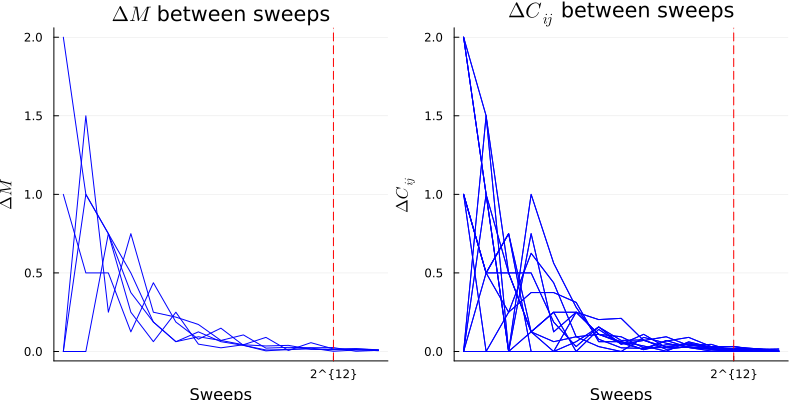

In [44]:
p1 = plot(n[1:end-1], ΔM, legend=false,
    xlabel = "Sweeps", ylabel = L"$\Delta M$", color=:blue,
    xscale =:log2, title = L"$\Delta M$ between sweeps")

vline!([2^12], line=(:red, :dash))
xticks!([2^12])

p2 = plot(n[1:end-1], ΔC, legend=false,
    xlabel = "Sweeps", ylabel = L"$\Delta C_{ij}$", color=:blue,
    xscale =:log2, title = L"$\Delta C_{ij}$ between sweeps")

vline!([2^12], line=(:red, :dash))
xticks!([2^12])

plot(p1, p2, layout = 2, size = (800, 400))

As one can see, the magnetisations and correlations fluctuate negligibly after at least $2^{12}$ Monte-Carlo sweeps and thus, this is a sufficient number of sweeps to reach equilibrium.

In [45]:
savefig("equilibrium.pdf")

"D:\\M.Sc. Courses\\3. SoSe 2022\\4. Data Analysis in Physics and Astronomy\\Exercises\\Statistical Inference_MLAB\\equilibrium.pdf"

In [46]:
N = 5
S = 10000
iterations = 500
rates = [0.05, 0.1, 0.5]

for i in 1:length(rates)
    m, Cij, _ = MH(ψ, N, S; n = 2^11, J = J, h = h)
    h_l, J_l, NLL_l = boltzmann_learn(S, iterations; 
        η = rates[i], n = 2^11, N = 5, M_d = m, Cij_d = Cij)
    
    # Save inferred parameter h
    save_object("h_l$(i)", h_l)

    # Save inferred parameter J
    save_object("J_l$(i)", J_l)

    # Save Negative Log-likelihood
    save_object("NLL_l$(i)", NLL_l)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:179m
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


In [47]:
N = 5
S = [1000, 5000, 10000]
iterations = 500

for i in 1:length(S)
    m, Cij, _ = MH(ψ, N, S[i]; n = 2^11, J = J, h = h)
    h_l, J_l, NLL_l = boltzmann_learn(S[i], iterations; 
        η = 0.05, n = 2^11, N = 5, M_d = m, Cij_d = Cij)
    
    # Save inferred parameter h
    save_object("h_S_l$(i)", h_l)

    # Save inferred parameter J
    save_object("J_S_l$(i)", J_l)

    # Save Negative Log-likelihood
    save_object("NLL_S_l$(i)", NLL_l)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


## Equilibrium Model

In [48]:
data = readdlm("bint.txt")
alt_data = (data.-0.5).*2;

In [49]:
part = Int(round(size(alt_data,2)/2))
train = alt_data[:, 1:part]
test = alt_data[:, part+1:end];

In [50]:
function params(data; L::Int = 160)
    N = size(data, 2)
    M = mean(data, dims=2)
    C = zeros(Float64, L, L)
    
    for i in 1:N
        C .+= data[:, i] * data[:, i]'
    end
    
    C ./= N
    return M, C
end

params (generic function with 1 method)

In [51]:
function sss(data; L::Int = 160)
    N = length(data[1,:])
    C = zeros(Float64, L, L)
    @showprogress for n in 1:N
        for i = 1:L, j = 1:L, k = 1:L
            C[i, j] += data[i, n]*data[j, n]*data[k, n]
        end
    end
    C ./= N*L
    return C
end

sss (generic function with 1 method)

In [52]:
M, C = params(test);
# Save magnetisation M
save_object("Magnetisation", M)

# Save correlation matrix C
save_object("CorrelationMatrix", C)

In [53]:
M, C = params(train)
S = 1000
iterations = 500
N = size(train, 1)
ψ = rand_state(N);

In [54]:
h, J, NLL = boltzmann_learn(S, iterations; η = 0.05, n = 2^11, N = N, M_d = M, Cij_d = C);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:55


In [55]:
# Save inferred parameter h
save_object("h_inf", h)

# Save inferred parameter J
save_object("J_inf", J)

# Save Negative Log-likelihood
save_object("NLL_inf", NLL)

In [29]:
N = 160
ψ = rand_state(N)
h = load_object("h_inf")
J = load_object("J_inf");

In [56]:
m, Cij, configs = MH(ψ, N, S; n = 2^11, J = J, h = h);

In [57]:
# Save inferred magnetisation m
save_object("mag_inf", m)

# Save inferred correlations Cij
save_object("corr_inf", Cij)

In [58]:
Cijk = sss(hcat(configs...));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


In [59]:
Cijk_test = sss(train[:,1:915]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [60]:
save_object("sss_train", Cijk)
save_object("sss_test", Cijk_test);

## Non equilibrium Model

In [61]:
function interactions_2(N::Int)
    int_s = randn(N, N)/N
    int_a = randn(N, N)/N
    sym_int = 0.5*(int_s + int_s')
    [sym_int[i,i] = 0 for i in 1:N]
    asm_int = 0.5*(int_a - int_a')
    return sym_int, asm_int
end

interactions_2 (generic function with 1 method)

In [62]:
function eff_field(ψ::Vector{Int}; h::Vector{Float64}, J::Matrix{Float64})
    Θ = J*ψ + h
    return Θ
end

eff_field (generic function with 1 method)

In [63]:
function modified_NLL(configs::Vector{Vector{Int}}; J::Matrix{Float64}, h::Vector{Float64})
    N = length(configs)
    NLL = 0.0
    for t in 1:N-1
        θ = eff_field(configs[t], h = h, J = J)
        ψ = configs[t + 1]
        NLL += (1/N) * sum(ψ.*θ .- log.(2*cosh.(θ)))
    end
    return NLL
end

modified_NLL (generic function with 1 method)

In [64]:
function glauber_update(ψ::Vector{Int}; J::Matrix{Float64}, h::Vector{Float64})
    ϕ = copy(ψ) 
    θ = eff_field(ψ, h = h, J = J)
    P = exp.(-ϕ.*θ) ./ (2*cosh.(θ))
    
    for i in 1:length(P)
        rand() < P[i] && (ϕ[i] *= -1)
    end
    
    return ϕ
end

glauber_update (generic function with 1 method)

In [65]:
function gen_configs(S::Int; n::Int, J::Matrix{Float64}, h::Vector{Float64})
    ψ = rand_state(length(h))
    configs = Vector{Vector{Int}}()
 
    for _ in 1:n
        ψ = glauber_update(ψ; J = J, h = h)
    end

    for i in 1:15*S
        ϕ = copy(ψ)
        ψ = glauber_update(ψ; J = J, h = h)
        if i%5 == 0
            flag = issetequal(ψ, ϕ)
            if flag == false
                i -= 1
            else
                push!(configs, copy(ψ))
            end
        end
    end
    
    M = mean(hcat(configs...), dims=2)
    
    return configs, M
end

gen_configs (generic function with 1 method)

In [66]:
N = 5
h = rand_fields(N)
_, Ja = interactions_2(N)
save_object("Ja_actual", Ja)
save_object("ha_actual", h);

In [67]:
steps = [0:15;]
n = 2 .^steps

M = zeros(Float64, length(n), N)

for i in 1:length(n)
    _, m2 = gen_configs(n[i], n = 0, J = Ja, h = h)
    M[i, :] = m2
end

ΔM = abs.(diff(M, dims=1));

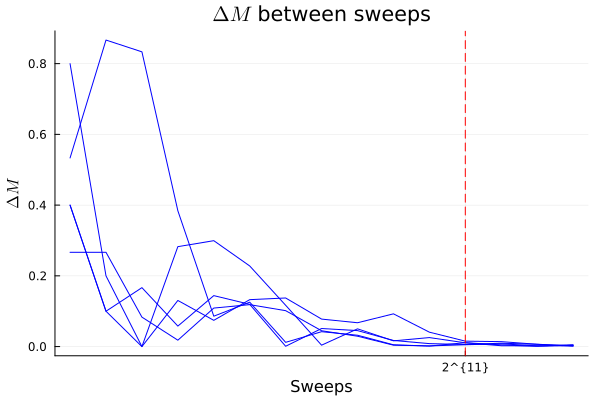

In [68]:
p1 = plot(n[1:end-1], ΔM, legend=false,
    xlabel = "Sweeps", ylabel = L"$\Delta M$", color=:blue,
    xscale =:log2, title = L"$\Delta M$ between sweeps")

vline!([2^11], line=(:red, :dash))
xticks!([2^11])

In [69]:
savefig("noneqbm.pdf")

"D:\\M.Sc. Courses\\3. SoSe 2022\\4. Data Analysis in Physics and Astronomy\\Exercises\\Statistical Inference_MLAB\\noneqbm.pdf"

In [70]:
function h_up2(states::Vector{Vector{Int}}, η::AbstractFloat;
        J::Matrix{Float64}, h::Vector{Float64})
    M = length(states)
    N = length(states[1])
    ∇h = zeros(Float64, N)
    
    for t in 1:M-1
        θ = eff_field(states[t], h = h, J = J)
        ∇h .+= (states[t + 1] .- tanh.(θ))
    end
    
    h .+= η * ∇h/M
    return h
end

h_up2 (generic function with 1 method)

In [75]:
function J_up2(states::Vector{Vector{Int}}, η::AbstractFloat;
        J::Matrix{Float64}, h::Vector{Float64})
    M = length(states)
    N = length(states[1])
    ∇J = zeros(Float64, N, N)
    
    for t in 1:M-1
        θ = eff_field(states[t], h = h, J = J)
        for i = 1:N, j = 1:N
            ∇J[i,j] = (states[t + 1][i]*states[t][j] - tanh(θ[i])*states[t][j])
        end
    end
    
    J .+= η * ∇J/M
    for i in 1:N
        J[i,i] = 0.0
    end
    return J
end

J_up2 (generic function with 1 method)

In [76]:
# Boltzmann Learning Algoritm

function glauber_learn(S::Int, iterations::Int; states::Vector{Vector{Int}},
        η::AbstractFloat, n::Int, N::Int, sym::Bool = false)
    h = rand_fields(N)
    if sym == false
        J = interactions_2(N)[2]
    else
        J = interactions_2(N)[1]
    end
    
    NLL_monitor = Float64[]
    
    @showprogress for i in 1:iterations
        h = h_up2(states, η, h = h, J = J)
        J = J_up2(states, η, h = h, J = J)
        
        NLL = modified_NLL(states, J = J, h = vec(h))
        push!(NLL_monitor, NLL)
    end
    
    return h, J, NLL_monitor
end

glauber_learn (generic function with 1 method)

In [77]:
S = 10000
iterations = 500;

In [78]:
series, _ = gen_configs(S, n = 2^11, J = Ja, h = h)
h_l, J_l, NLL_l = glauber_learn(S, iterations; states = series, η = 0.1, n = 2^11, N = 5)
    
# Save inferred parameter h
save_object("ha_l", h_l)

# Save inferred parameter J
save_object("Ja_l", J_l)

# Save Negative Log-likelihood
save_object("NLLa_l", NLL_l)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


In [11]:
function corr_tt(states::Vector{Vector{Int}})
    M = length(states)
    N = length(states[1])
    C = zeros(Float64, N, N)
    
    @showprogress for i in 1:length(states)-1
        C += (1/(M-1))*(states[i+1]*states[i]')
    end
    
    return C
end

corr_tt (generic function with 1 method)

In [14]:
N = 160   
Jsym, Jasm = interactions_2(N)
h3 = rand_fields(N) 
S = 1000
iterations = 100
save_object("h3_actual", h3)
save_object("J_sym", Jsym)
save_object("J_asm", Jasm);

In [15]:
series = Vector{Int64}[eachcol(train)...]
h_l, J_l, NLL_l = glauber_learn(S, iterations; states = series, η = 0.3, n = 2^11, N = 160, sym = true)

# Save inferred parameter h
save_object("h2_inf", h_l)

# Save inferred parameter J
save_object("Js_inf", J_l)

# Save Negative Log-likelihood
save_object("NLL2_inf", NLL_l)

Progress: 100%|█████████████████████████████████████████| Time: 2:06:37


In [16]:
h_l, J_l, NLL_l = glauber_learn(S, iterations; states = series, η = 0.3, n = 2^11, N = 160)

# Save inferred parameter h
save_object("h3_inf", h_l)

# Save inferred parameter J
save_object("Ja_inf", J_l)

# Save Negative Log-likelihood
save_object("NLL3_inf", NLL_l)

Progress: 100%|█████████████████████████████████████████| Time: 2:07:18


In [20]:
hs = load_object("h2_inf")
Js = load_object("Js_inf"); 

In [17]:
S = 1000;

In [22]:
series_s, m_s = gen_configs(S, n = 2^11, J = Js, h = hs)
Cs = corr_tt(series_s);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [23]:
test_s = Vector{Int64}[eachcol(test)...]
Ctest = corr_tt(test_s);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


In [24]:
ha = load_object("h3_inf")
Ja = load_object("Ja_inf"); 

In [25]:
series_a, m_a = gen_configs(S, n = 2^11, J = Ja, h = ha)
Ca = corr_tt(series_a);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [26]:
save_object("Ctest", Ctest)
save_object("Cs", Cs)
save_object("Ca", Ca)